In [1]:
from keras import models, layers, optimizers
from keras.applications import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import load_model
from keras import models

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4674599064224156574
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12215123906651476879
physical_device_desc: "device: XLA_CPU device"
]


In [3]:
import numpy as np
import keras
import warnings
from matplotlib import pyplot as plt
import cv2
warnings.filterwarnings('ignore')
import random

In [4]:
#from keras.applications.resnet50 import preprocess_input, decode_predictions
#from keras.applications.MobileNet import preprocess_input
#from keras.applications.mobilenet import preprocess_input

In [5]:
def image_process(img,r_size,c_size):
    scaled_image = cv2.resize(img, (r_size, c_size))
    #rot_image = np.rot90(scaled_image,-1)
    scaled_image = scaled_image/127.5-1
    return scaled_image

In [6]:
dire = ''
filename = 'yeah2.mov'

In [7]:
def extract_image_data(dire = dire, filename = filename,r_size=224,c_size=224):
    file = dire+ filename
    vidcap = cv2.VideoCapture(file)
    flag = True
    image_list = []
    cnt = 0
    while flag:
        flag,img = vidcap.read()
        if flag:
            image_list += [image_process(img,r_size,c_size)]
            cnt += 1
    return image_list

In [8]:
if False:
    image_list = extract_image_data(dire,filename)
    print(image_list[0].shape)
    print(len(image_list))

In [9]:
if False:
    imgplot = plt.imshow(image_list[0])

In [10]:
from os import listdir
from os.path import isfile, join
files = [f for f in listdir('./') if isfile(join('./', f)) if f[-3:] == 'mov']

In [11]:
files.sort()
files

['fist.mov',
 'fist1.mov',
 'fist2.mov',
 'five.mov',
 'five2.mov',
 'thumb.mov',
 'thumb2.mov',
 'yeah.mov',
 'yeah2.mov']

In [17]:
image_dataset = []
category_dataset = []
proj = {}
conv = {}
for filename in files[:-1]:
    image_list = extract_image_data(dire,filename)
    image_dataset += image_list
    gesture = filename.split('.')[0]
    while not gesture[-1].isalpha():
        gesture = gesture[:-1]
    if gesture not in conv:
        conv[gesture] = len(conv.keys())
    proj[conv[gesture]] = gesture
    category_dataset += [conv[gesture] for _ in image_list]
    print(filename,gesture,conv[gesture],proj[conv[gesture]])
image_dataset = np.asarray(image_dataset)
category_dataset = np.asarray(category_dataset)
category_dataset = keras.utils.to_categorical(category_dataset)

fist.mov fist 0 fist
fist1.mov fist 0 fist
fist2.mov fist 0 fist
five.mov five 1 five
five2.mov five 1 five
thumb.mov thumb 2 thumb
thumb2.mov thumb 2 thumb
yeah.mov yeah 3 yeah


In [18]:
proj

{0: 'fist', 1: 'five', 2: 'thumb', 3: 'yeah'}

In [19]:
conv

{'fist': 0, 'five': 1, 'thumb': 2, 'yeah': 3}

In [20]:
print(image_dataset[0])

[[[-0.23921569 -0.10588235  0.01960784]
  [-0.22352941 -0.09019608  0.03529412]
  [-0.21568627 -0.06666667  0.0745098 ]
  ...
  [ 0.99215686  1.          1.        ]
  [ 1.          1.          1.        ]
  [ 1.          1.          1.        ]]

 [[-0.24705882 -0.12156863  0.02745098]
  [-0.25490196 -0.12941176  0.01960784]
  [-0.2627451  -0.11372549  0.02745098]
  ...
  [ 1.          1.          1.        ]
  [ 1.          1.          1.        ]
  [ 1.          1.          1.        ]]

 [[-0.23137255 -0.12941176  0.03529412]
  [-0.23137255 -0.12156863  0.04313725]
  [-0.27843137 -0.16078431 -0.00392157]
  ...
  [ 1.          1.          1.        ]
  [ 1.          1.          1.        ]
  [ 1.          1.          1.        ]]

 ...

 [[-0.80392157 -0.82745098 -0.81960784]
  [-0.78823529 -0.82745098 -0.81176471]
  [-0.78823529 -0.82745098 -0.81176471]
  ...
  [-0.61568627 -0.67843137 -0.61568627]
  [-0.56078431 -0.48235294 -0.42745098]
  [-0.40392157 -0.34117647 -0.19215686]]

 [

In [21]:
print(image_dataset.shape)
print(category_dataset.shape)

(7350, 224, 224, 3)
(7350, 4)


In [22]:
r_size=224
c_size=224

model = keras.applications.MobileNet(include_top=False,  weights='imagenet', input_shape=(r_size, c_size, 3),  pooling=None)

In [23]:
#print(model.summary())

In [24]:
%%time
processed_input = model.predict(image_dataset)

CPU times: user 24min 44s, sys: 9min 13s, total: 33min 58s
Wall time: 4min 21s


In [26]:
#train-test split
indices = np.random.permutation(processed_input.shape[0])
ratio = 0.8
training_idx, test_idx = indices[:int(processed_input.shape[0]*ratio)], indices[int(processed_input.shape[0]*ratio):]
x_train, x_test = processed_input[training_idx,:], processed_input[test_idx,:]
y_train, y_test = category_dataset[training_idx,:], category_dataset[test_idx,:]

In [27]:
print(image_dataset[0].shape)
print(processed_input.shape)

(224, 224, 3)
(7350, 7, 7, 1024)


In [28]:
print(category_dataset.shape)

(7350, 4)


In [40]:
top_model = models.Sequential()
top_model.add(layers.Flatten(input_shape=(7, 7, 1024)))
top_model.add(layers.Dense(128, activation='relu'))
#top_model.add(layers.Dense(64, activation='relu'))
#top_model.add(layers.Dropout(0.6))
#top_model.add(layers.Dense(32, activation='relu'))
top_model.add(layers.Dropout(0.6))
#top_model.add(layers.Dense(16, activation='relu'))
top_model.add(layers.Dense(len(proj), activation='softmax'))

top_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
for _ in range(20):
    top_model.fit(x_train, y_train, epochs=1, batch_size=64, verbose=1,validation_data=(x_test, y_test))
    print(top_model.predict_classes(x_test[_*50:_*50+50]))
    print(np.asarray([sum([int((i)*val[i]) for i in range(4)]) for val in y_test[_*50:_*50+50]]))

Train on 5880 samples, validate on 1470 samples
Epoch 1/1
5880/5880 [==============================] - 26s 4ms/step - loss: 3.3848 - acc: 0.7728 - val_loss: 1.1921e-07 - val_acc: 1.0000
[0 0 2 1 0 2 0 3 3 0 0 0 2 2 2 0 0 0 2 0 0 1 3 3 2 2 3 0 2 0 2 0 3 3 2 3 3
 2 3 3 0 0 0 0 0 3 0 0 0 3]
[0 0 2 1 0 2 0 3 3 0 0 0 2 2 2 0 0 0 2 0 0 1 3 3 2 2 3 0 2 0 2 0 3 3 2 3 3
 2 3 3 0 0 0 0 0 3 0 0 0 3]
Train on 5880 samples, validate on 1470 samples
Epoch 1/1
5880/5880 [==============================] - 9s 2ms/step - loss: 0.2247 - acc: 0.9815 - val_loss: 0.0650 - val_acc: 0.9952
[0 0 1 2 1 0 0 0 3 3 0 0 1 1 3 1 2 2 0 2 2 0 0 1 0 3 2 0 0 0 0 2 0 0 3 1 3
 0 0 0 2 0 0 0 1 0 2 2 1 1]
[0 0 1 2 1 0 0 0 3 3 0 0 1 1 3 1 2 2 0 2 2 0 0 1 0 3 2 0 0 0 0 2 0 0 3 1 3
 0 0 0 2 0 0 0 1 0 2 2 1 1]
Train on 5880 samples, validate on 1470 samples
Epoch 1/1
5880/5880 [==============================] - 3s 522us/step - loss: 0.1673 - acc: 0.9866 - val_loss: 1.1921e-07 - val_acc: 1.0000
[0 0 2 1 3 2 1 1 1 0 3 1 0 2 0 2 1

In [42]:
pred = [proj[i] for i in top_model.predict_classes(processed_input)]

In [43]:
#save trained model
from keras.models import load_model

top_model.save('top_model.h5')
del top_model

In [44]:
import json

with open('proj.json', 'w') as fp:
    json.dump(proj, fp)

In [45]:
#load trained model
top_model = load_model('top_model.h5')

In [46]:
def get_command(img,r_size=224,c_size=224):
    scaled_image = cv2.resize(img, (r_size, c_size))
    cmd_id = top_model.predict_classes(model.predict(np.asarray([scaled_image])))[0]
    return cmd_id

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


fist
CPU times: user 557 ms, sys: 830 ms, total: 1.39 s
Wall time: 768 ms


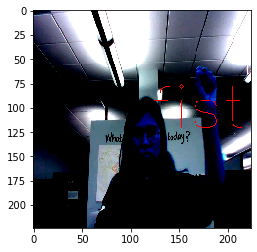

In [47]:
%%time
frame = image_dataset[1200]
cmd_id = get_command(frame)
cmd = proj[cmd_id]
print(cmd)
plt.imshow(cv2.putText(frame,cmd, (120,120), cv2.FONT_HERSHEY_SIMPLEX, 2, 255))

In [48]:
%%time
a = model.predict(np.asarray([cv2.resize(frame, (r_size, c_size))]))

CPU times: user 276 ms, sys: 109 ms, total: 385 ms
Wall time: 80.4 ms


In [49]:
image_dataset[530].shape

(224, 224, 3)

thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
five
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
five
five
five
five
five
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
five
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
five
five
thumb
five
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
thumb
th

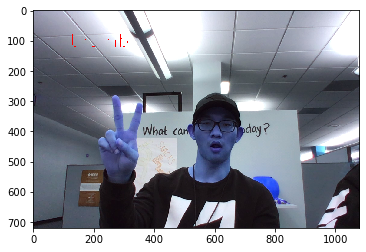

In [51]:
vidcap = cv2.VideoCapture('yeah2.mov')
flag = True
while flag:
    flag,frame = vidcap.read()
    if flag:
        cmd_id = get_command(frame)
        cmd = proj[cmd_id]
        print(cmd)
        plt.imshow(cv2.putText(frame,cmd, (120,120), cv2.FONT_HERSHEY_SIMPLEX, 2, 255))